In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [5]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
df= pd.read_csv("/content/drive/MyDrive/airlien_Tweets.csv")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


# Data Preprocessing

In [7]:
print("Shape of the dataframe is",df.shape)
print("The number of nulls in each column are \n", df.isna().sum())

Shape of the dataframe is (14640, 15)
The number of nulls in each column are 
 tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [9]:
df.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [11]:
df.notnull()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,False,False,False,True,True,False,True,False,True,False,False,True,False,True,False
1,False,False,False,True,False,False,True,False,True,False,False,True,False,True,False
2,False,False,False,True,True,False,True,False,True,False,False,True,False,False,False
3,False,False,False,False,False,False,True,False,True,False,False,True,False,True,False
4,False,False,False,False,False,False,True,False,True,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,False,False,False,True,False,False,True,False,True,False,False,True,False,True,True
14636,False,False,False,False,False,False,True,False,True,False,False,True,False,False,True
14637,False,False,False,True,True,False,True,False,True,False,False,True,False,False,True
14638,False,False,False,False,False,False,True,False,True,False,False,True,False,False,False


In [12]:
print("Percentage null or na values in df")
((df.isnull() | df.isna()).sum() * 100 / df.index.size).round(2)

Percentage null or na values in df


tweet_id                         0.00
airline_sentiment                0.00
airline_sentiment_confidence     0.00
negativereason                  37.31
negativereason_confidence       28.13
airline                          0.00
airline_sentiment_gold          99.73
name                             0.00
negativereason_gold             99.78
retweet_count                    0.00
text                             0.00
tweet_coord                     93.04
tweet_created                    0.00
tweet_location                  32.33
user_timezone                   32.92
dtype: float64

In [13]:
del df['tweet_coord']
del df['airline_sentiment_gold']
del df['negativereason_gold']
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Total number of tweets for each airline 
  airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline_sentiment, dtype: int64


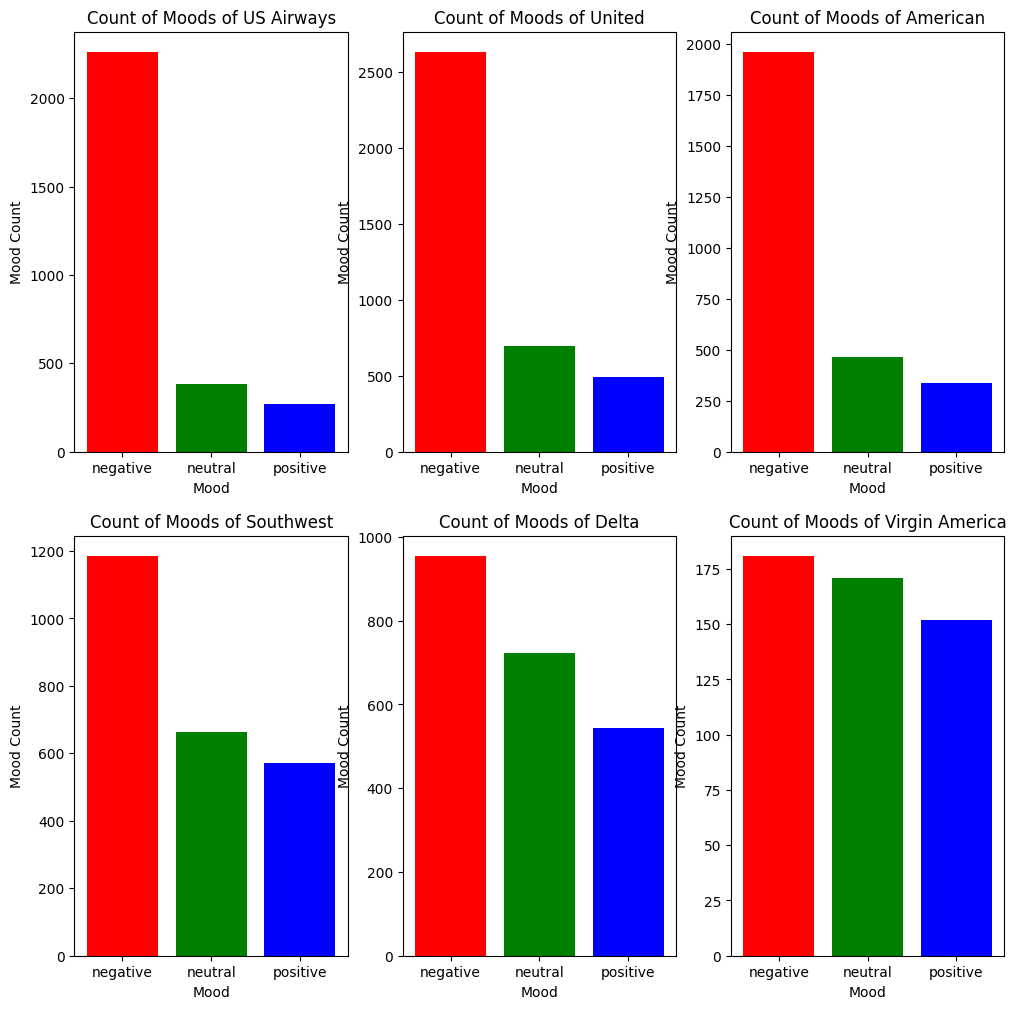

In [14]:
#sentiments for each airline¶
print("Total number of tweets for each airline \n ",df.groupby('airline')['airline_sentiment'].count().sort_values(ascending=False))
airlines= ['US Airways','United','American','Southwest','Delta','Virgin America']
plt.figure(1,figsize=(12, 12))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    new_df=df[df['airline']==i]
    count=new_df['airline_sentiment'].value_counts()
    Index = [1,2,3]
    plt.bar(Index,count, color=['red', 'green', 'blue'])
    plt.xticks(Index,['negative','neutral','positive'])
    plt.ylabel('Mood Count')
    plt.xlabel('Mood')
    plt.title('Count of Moods of '+i)

Most used words in Positive and Negative tweets

In [15]:
from wordcloud import WordCloud,STOPWORDS

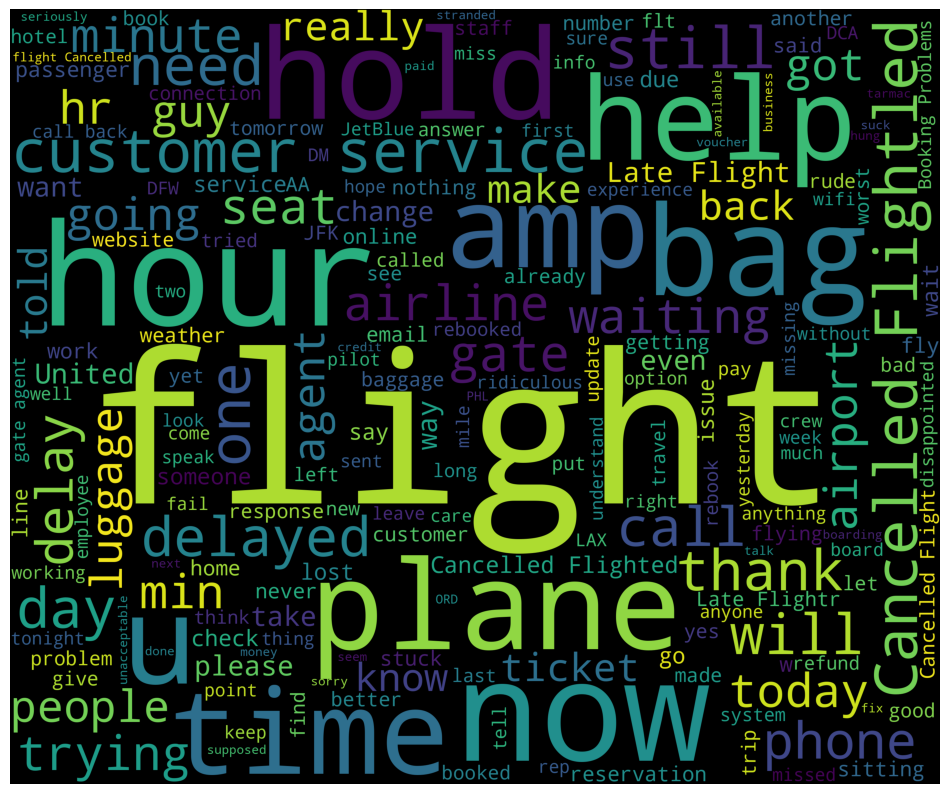

In [16]:
#Negative sentiments of tweets
new_df=df[df['airline_sentiment']=='negative']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

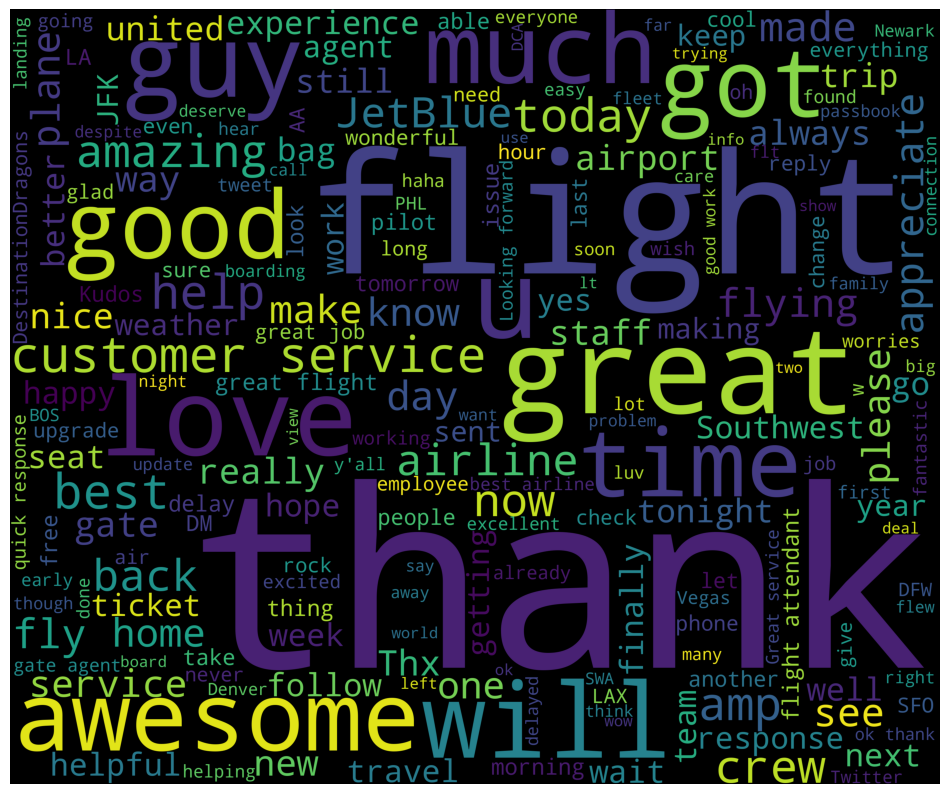

In [17]:
#Positive sentiments of tweets
new_df=df[df['airline_sentiment']=='positive']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [19]:
#To calculate the highest frequency words in postive sentimental tweets

def freq(str):

    # break the string into list of words
    str = str.split()
    str2 = []

    # loop till string values present in list str
    for i in str:

        # checking for the duplicacy
        if i not in str2:

            # insert value in str2
            str2.append(i)

    for i in range(0, len(str2)):
        if(str.count(str2[i])>50):
            print('Frequency of', str2[i], 'is :', str.count(str2[i]))

print(freq(cleaned_word))


Frequency of to is : 923
Frequency of the is : 924
Frequency of time is : 59
Frequency of I is : 574
Frequency of fly is : 54
Frequency of this is : 143
Frequency of :) is : 96
Frequency of it is : 166
Frequency of was is : 226
Frequency of and is : 416
Frequency of an is : 74
Frequency of good is : 75
Frequency of so is : 163
Frequency of much is : 54
Frequency of is is : 219
Frequency of a is : 501
Frequency of great is : 144
Frequency of my is : 320
Frequency of &amp; is : 77
Frequency of on is : 327
Frequency of I'm is : 67
Frequency of flying is : 59
Frequency of your is : 212
Frequency of all is : 92
Frequency of from is : 124
Frequency of Thanks! is : 69
Frequency of for is : 658
Frequency of flight is : 263
Frequency of but is : 91
Frequency of you is : 509
Frequency of would is : 56
Frequency of be is : 135
Frequency of with is : 195
Frequency of you. is : 77
Frequency of love is : 85
Frequency of You is : 62
Frequency of are is : 120
Frequency of of is : 236
Frequency of that

Words like Thanks, best, customer , love, flying , good are understandably present in the most frequent words of positive tweets.

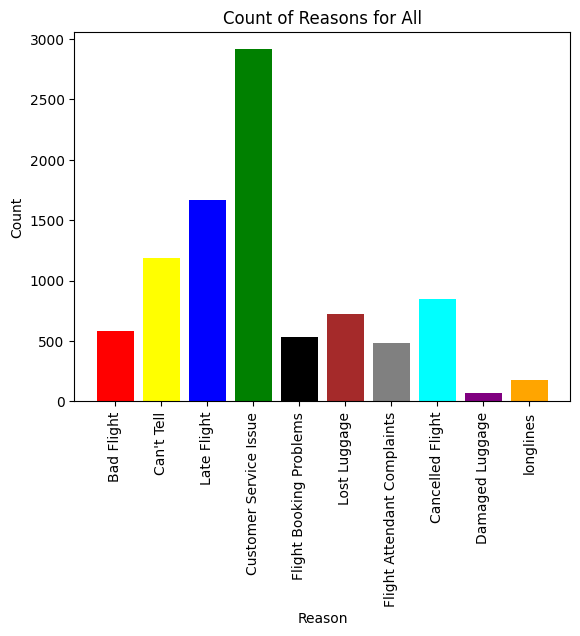

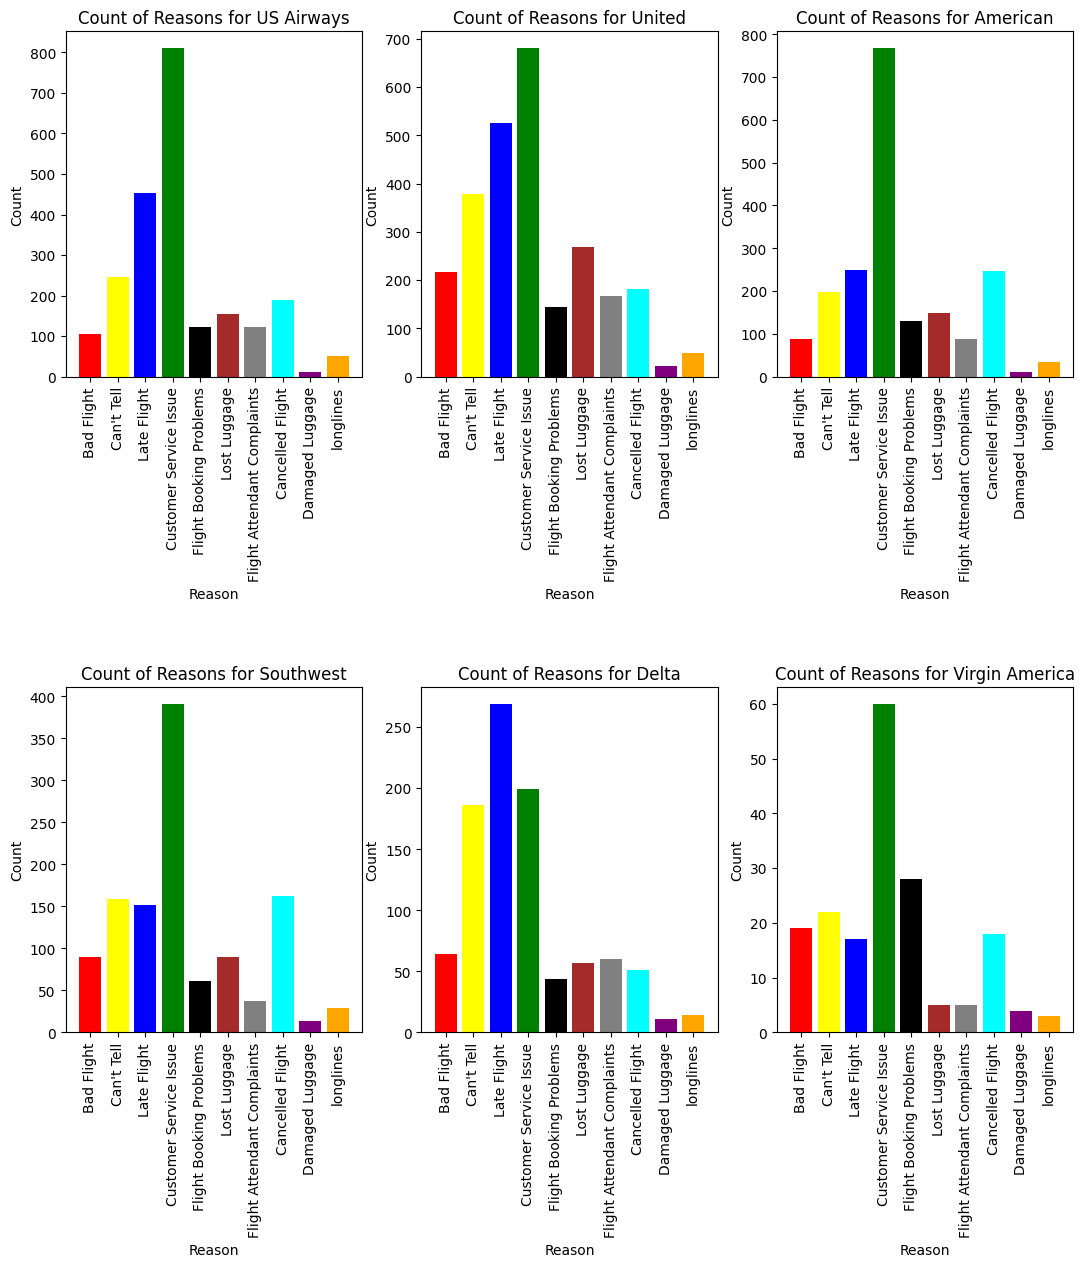

In [20]:
#get the number of negative reasons
df['negativereason'].nunique()

NR_Count=dict(df['negativereason'].value_counts(sort=False))
def NR_Count(Airline):
    if Airline=='All':
        a=df
    else:
        a=df[df['airline']==Airline]
    count=dict(a['negativereason'].value_counts())
    Unique_reason=list(df['negativereason'].unique())
    Unique_reason=[x for x in Unique_reason if str(x) != 'nan']
    Reason_frame=pd.DataFrame({'Reasons':Unique_reason})
    Reason_frame['count']=Reason_frame['Reasons'].apply(lambda x: count[x])
    return Reason_frame
def plot_reason(Airline):

    a=NR_Count(Airline)
    count=a['count']
    Index = range(1,(len(a)+1))
    plt.bar(Index,count, color=['red','yellow','blue','green','black','brown','gray','cyan','purple','orange'])
    plt.xticks(Index,a['Reasons'],rotation=90)
    plt.ylabel('Count')
    plt.xlabel('Reason')
    plt.title('Count of Reasons for '+Airline)

plot_reason('All')
plt.figure(2,figsize=(13, 13))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    plt.subplots_adjust(hspace=0.9)
    plot_reason(i)

In [21]:
#Negative comments as per specific timeline
date = df.reset_index()
#convert the Date column to pandas datetime
date.tweet_created = pd.to_datetime(date.tweet_created)
#Reduce the dates in the date column to only the date and no time stamp using the 'dt.date' method
date.tweet_created = date.tweet_created.dt.date
date.tweet_created.head()
df = date
day_df = df.groupby(['tweet_created','airline','airline_sentiment']).size()
# day_df = day_df.reset_index()
day_df

tweet_created  airline         airline_sentiment
2015-02-16     Delta           negative               1
                               neutral                1
               United          negative               2
2015-02-17     Delta           negative             108
                               neutral               86
                                                   ... 
2015-02-24     United          neutral               49
                               positive              25
               Virgin America  negative              10
                               neutral                6
                               positive              13
Length: 136, dtype: int64

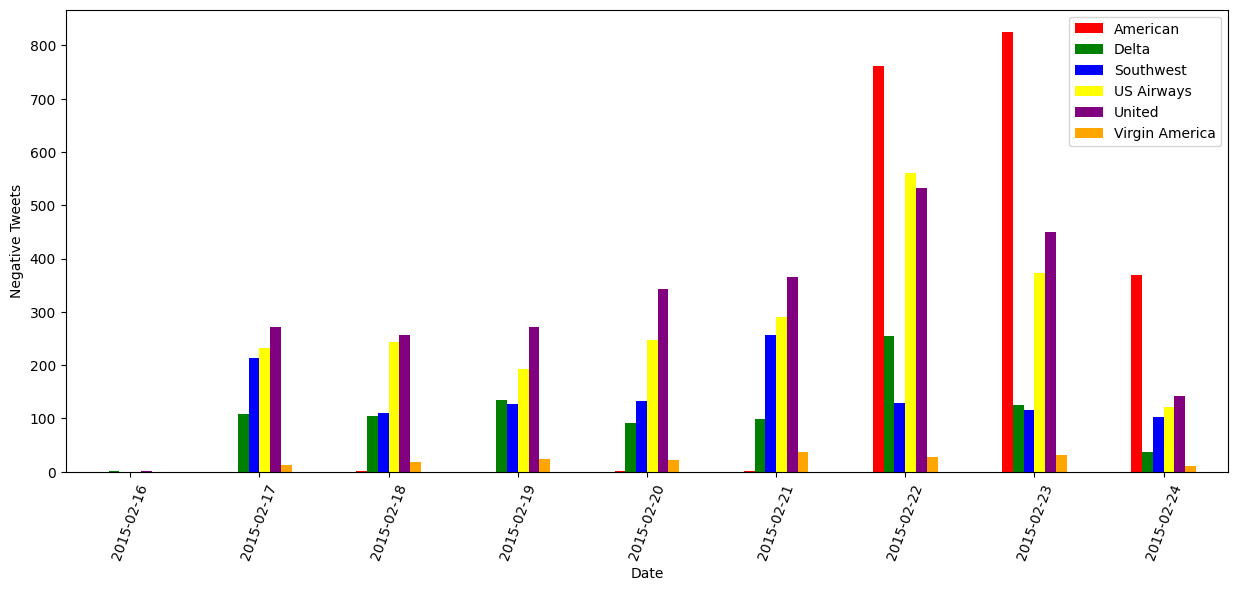

In [22]:
#visualization for negative tweets.
day_df = day_df.loc(axis=0)[:,:,'negative']

#groupby and plot data
ax2 = day_df.groupby(['tweet_created','airline']).sum().unstack().plot(kind = 'bar', color=['red', 'green', 'blue','yellow','purple','orange'], figsize = (15,6), rot = 70)
labels = ['American','Delta','Southwest','US Airways','United','Virgin America']
ax2.legend(labels = labels)
ax2.set_xlabel('Date')
ax2.set_ylabel('Negative Tweets')
plt.show()


# Preprocessing the tweet text data

In [27]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [28]:
def tweet_to_words(tweet):
    letters_only = re.sub("[^a-zA-Z]", " ",tweet)
    words = letters_only.lower().split()
    stops = set(stopwords.words("english"))
    meaningful_words = [w for w in words if not w in stops]
    return( " ".join( meaningful_words ))

df['clean_tweet']=df['text'].apply(lambda x: tweet_to_words(x))

In [29]:
#Splititng data at 80/20 ratio
train,test = train_test_split(df,test_size=0.2,random_state=42)

In [30]:
train_clean_tweet=[]
for tweet in train['clean_tweet']:
    train_clean_tweet.append(tweet)
test_clean_tweet=[]
for tweet in test['clean_tweet']:
    test_clean_tweet.append(tweet)

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
v = CountVectorizer(analyzer = "word")
train_features= v.fit_transform(train_clean_tweet)
test_features=v.transform(test_clean_tweet)

In [41]:
Classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=200)]

Accuracy of DecisionTreeClassifieris 0.682035519125683
              precision    recall  f1-score   support

    negative       0.79      0.80      0.79      1859
     neutral       0.44      0.41      0.43       633
    positive       0.55      0.58      0.57       436

    accuracy                           0.68      2928
   macro avg       0.59      0.60      0.60      2928
weighted avg       0.68      0.68      0.68      2928



<Figure size 640x480 with 0 Axes>

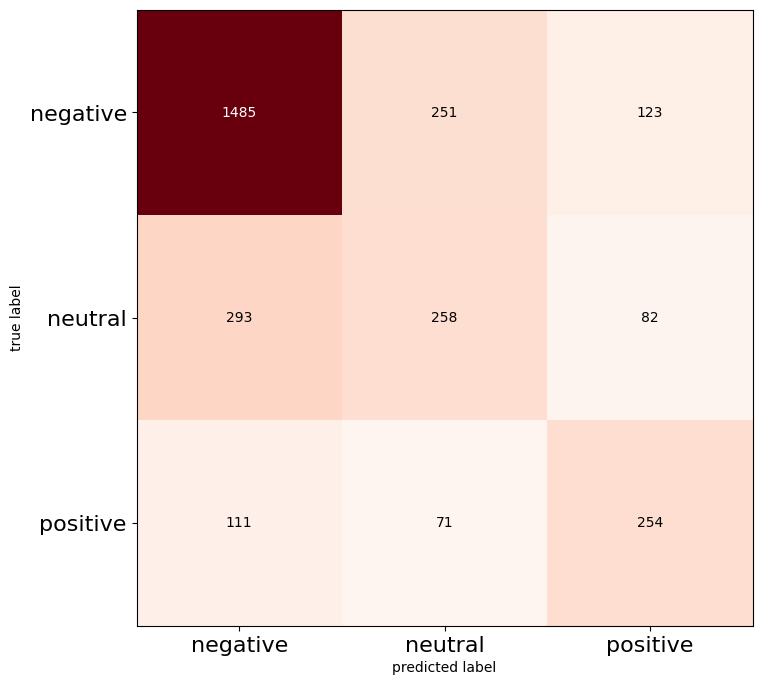

Accuracy of RandomForestClassifieris 0.7701502732240437
              precision    recall  f1-score   support

    negative       0.91      0.82      0.86      2098
     neutral       0.45      0.58      0.51       449
    positive       0.61      0.73      0.67       381

    accuracy                           0.77      2928
   macro avg       0.66      0.71      0.68      2928
weighted avg       0.80      0.77      0.78      2928



<Figure size 640x480 with 0 Axes>

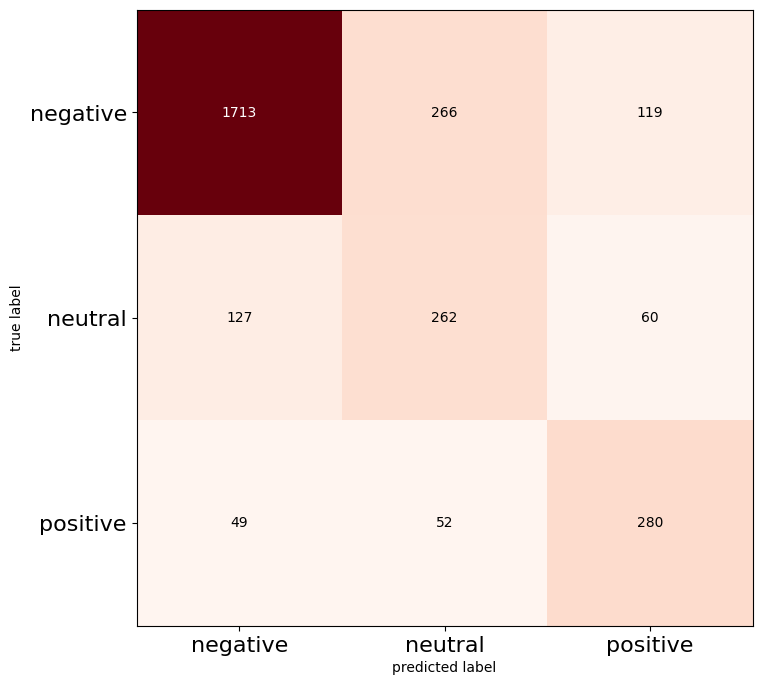

In [45]:
dense_features=train_features.toarray()
dense_test= test_features.toarray()
Accuracy=[]
Model=[]
for classifier in Classifiers:
    try:
        fit = classifier.fit(train_features,train['airline_sentiment'])
        pred = fit.predict(test_features)
    except Exception:
        fit = classifier.fit(dense_features,train['airline_sentiment'])
        pred = fit.predict(dense_test)
    accuracy = accuracy_score(pred,test['airline_sentiment'])
    Accuracy.append(accuracy)
    Model.append(classifier.__class__.__name__)
    print('Accuracy of '+classifier.__class__.__name__+'is '+str(accuracy))
    print(classification_report(pred,test['airline_sentiment']))
    cm=confusion_matrix(pred , test['airline_sentiment'])
    plt.figure()
    plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Reds)
    unique_labels = np.unique(test['airline_sentiment'])
    plt.xticks(range(len(unique_labels)), unique_labels, fontsize=16, color='black')
    plt.yticks(range(len(unique_labels)), unique_labels, fontsize=16)
    plt.show()

# Conclusion
1) Random Forest Classifier gives us the best accuracy score, precision scores according to the classification report.

2) The confusion matrix shows Random Forest Classifier gives better results than the Decision Tree Classifier.
